In [1]:
import math

import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import scipy.special as special
from scipy.stats import poisson, uniform, norm
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from mpl_axes_aligner import align
from multiprocessing import Pool, cpu_count
from functools import partial
from scipy.signal import savgol_filter

import wf_func as wff

plt.style.use('classic')
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

import matplotlib
matplotlib.use('Agg')
%matplotlib inline

In [2]:
def my_cmap():
    plasma = cm.get_cmap('plasma', 65536)
    newcolors = plasma(np.linspace(0, 1, 65536))
    white = np.array([65535/65536, 65535/65536, 65535/65536, 1])
    newcolors[:1, :] = white
    newcmp = ListedColormap(newcolors)
    return newcmp

# 模拟中的时间分布

In [3]:
methods = ['lucyddm', 'xiaopeip', 'takara', 'mcmc', 'fbmp']
methods = ['fbmp']
labels = {'truth':'\mathrm{Truth}', 'lucyddm':'\mathrm{LucyDDM}', 'xiaopeip':'\mathrm{Fitting}', 'takara':'\mathrm{CNN}', 'fbmp':'\mathrm{FBMP}', 'fbmpwave':'\mathrm{FBMP}', 'mcmc':'\mathrm{MCMC}', 'mcmcwave':'\mathrm{MCMC}'}

para = '05-40-10'
[Mu, Tau, Sigma] = [int(i) for i in para.split('-')]
wf = h5py.File('waveform/' + para + '.h5', 'r', libver='latest', swmr=True)
spe_pre = wff.read_model('spe.h5', wff.nshannon)
p = spe_pre[0]['parameters']
mycmp = my_cmap()
colors = {'truth':'k', 'lucyddm':'g', 'xiaopeip':'m', 'takara':'y', 'mcmc':'r', 'fbmp':'b', 'threshold':'c', 'omp':'C1'}
t0 = wf['SimTruth/T']
pelist = wf['SimTriggerInfo/PEList']
wave = wf['Readout/Waveform']

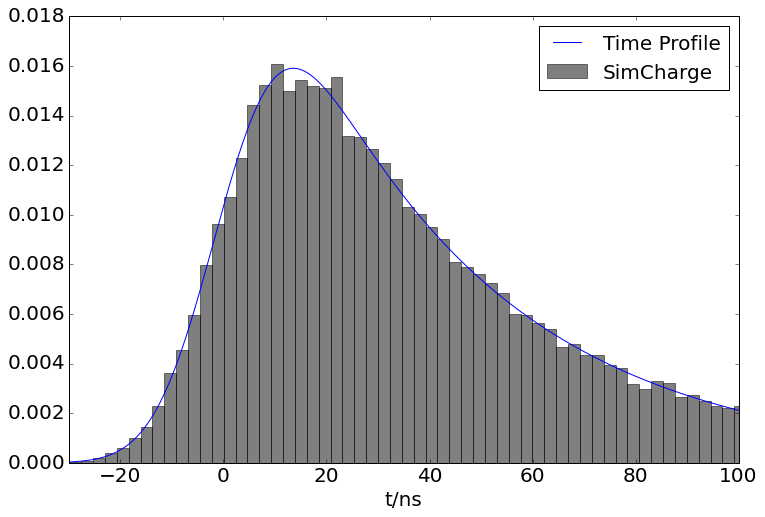

In [4]:
plt.close()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
t = np.arange(-40, 120, 0.1)
ax.plot(t, wff.convolve_exp_norm(t, Tau, Sigma), label='Time Profile')
ax.hist(pelist['HitPosInWindow'] - np.repeat(t0['T0'], np.unique(pelist['TriggerNo'], return_counts=True)[1]), bins=200, alpha=0.5, label='SimCharge', density=True, color=colors['truth'])
ax.set_xlim(-30, 100)
ax.legend()
ax.set_xlabel('t/ns')
plt.show()

# 模拟中的电荷分布

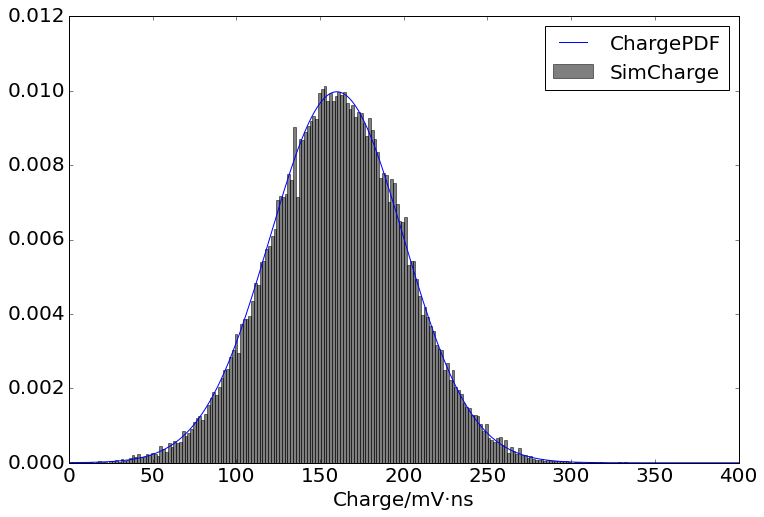

In [5]:
plt.close()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
t = np.arange(0, 1000, 0.1)
ax.plot(t, norm.pdf(t, loc=160., scale=40.) / (1 - norm.cdf(0, loc=160., scale=40.)), label='ChargePDF')
ax.hist(pelist['Charge'], bins=200, alpha=0.5, label='SimCharge', density=True, color=colors['truth'])
ax.set_xlim(0, 400)
ax.legend()
ax.set_xlabel('Charge/mV·ns')
plt.show()

# 重建结果的时间分布

# 重建结果的电荷分布

# 单事例分析

# 检查各方法的稀疏性

# 探索针对稀疏参数的优化方法

# 检查 MCMC 中 A 的值

# 检查单光电子响应的频域

In [6]:
with h5py.File('waveform/' + para + '.h5', 'r', libver='latest', swmr=True) as ipt:
    ent = ipt['Readout/Waveform'][:]
    tru = ipt['SimTriggerInfo/PEList'][:]
    gmu = ipt['SimTriggerInfo/PEList'].attrs['gmu']
    gsigma = ipt['SimTriggerInfo/PEList'].attrs['gsigma']
    npe = ipt['SimTruth/T'].attrs['npe']

# 检查初始化

In [ ]:
spe_pre = wff.read_model('spe.h5', wff.nshannon)
chunk = len(ent) // 100 + 1
slices = np.vstack((np.arange(0, len(ent), chunk), np.append(np.arange(chunk, len(ent), chunk), len(ent)))).T.astype(int).tolist()

def test(a0, a1):
    l = a1 - a0
    s = np.zeros(l).astype(int)
    r = np.zeros(l).astype(int)
    w = np.zeros(int(l * 0.1))
    start = 0
    end = 0
    for i in range(a0, a1):
        cid = ent[i]['ChannelID']
        eid = ent[i]['TriggerNo']

        A, wave_r, tlist, t0_init, t0_init_delta, char_init, n = wff.initial_params(ent[i]['Waveform'], spe_pre[cid], Mu, Tau, Sigma, 160., 40., 0.1, 3, spe_pre[0]['parameters'], 4, 3, is_t0=True, is_delta=False, nshannon=wff.nshannon)
        truth = np.sort(tru[(tru['TriggerNo'] == eid) & (tru['PMTId'] == cid)], kind='stable', order=['TriggerNo', 'PMTId', 'HitPosInWindow'])
        truth_time = np.round(truth['HitPosInWindow']).astype(int)
        s[i - a0] = len(truth_time) - np.isin(truth_time, tlist).sum().astype(int)
        r[i - a0] = len(tlist)
        t = truth['Charge'][np.logical_not(np.isin(truth_time, tlist))]
        end = start + len(t)
        w[start:end] = t
        start = end
    w = w[:end]
    return s, r, w

with Pool(100) as pool:
    result = pool.starmap(partial(test), slices)

s = np.hstack([result[i][0] for i in range(len(slices))])
r = np.hstack([result[i][1] for i in range(len(slices))])
w = np.hstack([result[i][2] for i in range(len(slices))])
    
plt.close()
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(131)
b, c = np.unique(s, return_counts=True)
ax.bar(b, c, alpha=0.6)
ax.set_yscale('log')
ax.set_ylim(0.9, 1e4)
ax = fig.add_subplot(132)
# b, c = np.unique(r, return_counts=True)
# ax.bar(b, c, alpha=0.6)
ax.hist(r, bins=100, alpha=0.6)
ax = fig.add_subplot(133)
# b, c = np.unique(r, return_counts=True)
# ax.bar(b, c, alpha=0.6)
ax.hist(tru['Charge'][tru['Charge'] < 60], bins=20, alpha=0.6, label='all')
ax.hist(w, bins=20, alpha=0.6, label='untest')
ax.legend(loc='upper left')
plt.savefig('t.png')
plt.show()

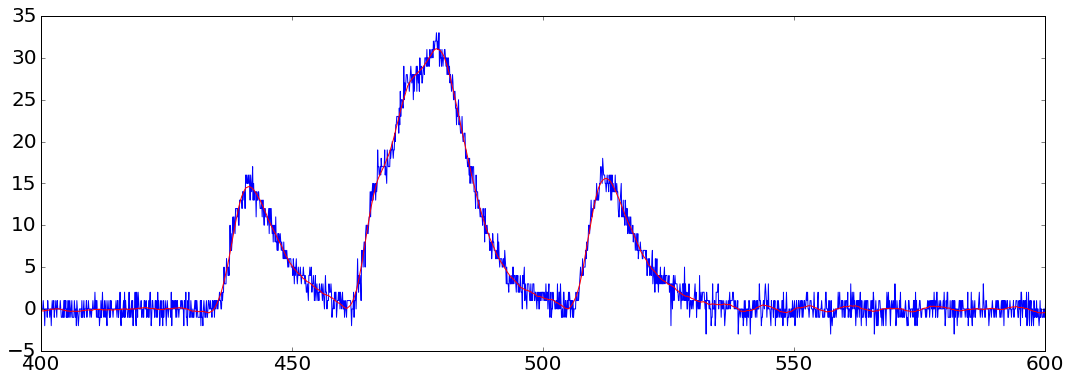

In [10]:
plt.close()
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot()
ax.plot(np.arange(0, 1029, 1/wff.nshannon), ent[0]['Waveform'], label='origin', color='b')
ax.plot(np.arange(0, 1029, 1/wff.nshannon), savgol_filter(ent[0]['Waveform'], 11 * (wff.nshannon if wff.nshannon % 2 == 1 else wff.nshannon + 1), 4), label='savgol', color='r')
ax.set_xlim(400, 600)
plt.show()

100%|██████████| 9990/9990 [00:14<00:00, 692.62it/s]


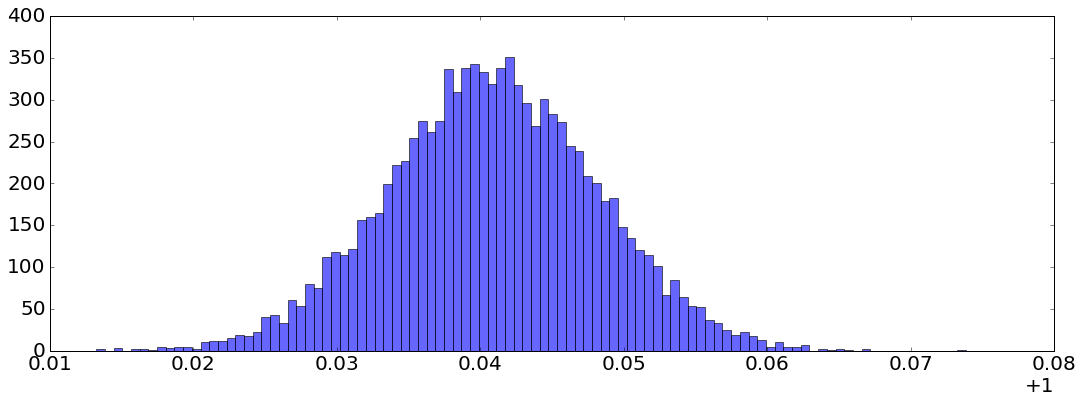

In [11]:
s = np.zeros(len(ent))
for i in tqdm(range(len(ent))):
    pan = np.arange(len(ent[i]['Waveform'])) / wff.nshannon
    cid = ent[i]['ChannelID']
    eid = ent[i]['TriggerNo']
    truth = np.sort(tru[(tru['TriggerNo'] == eid) & (tru['PMTId'] == cid)], kind='stable', order=['TriggerNo', 'PMTId', 'HitPosInWindow'])
    pet_ans = truth['HitPosInWindow']
    cha_ans = truth['Charge']
    wav_ans = np.sum([np.where(pan > pet_ans[j], wff.spe(pan - pet_ans[j], tau=p[0], sigma=p[1], A=p[2]) * cha_ans[j] / spe_pre[cid]['spe'].sum() * wff.nshannon, 0) for j in range(len(pet_ans))], axis=0)
    s[i] = np.std(wav_ans - ent[i]['Waveform'])
plt.close()
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot()
ax.hist(s, bins=100, alpha=0.6)
plt.show()